In [26]:
from scipy.stats import norm, expon, poisson as pois, binom, uniform as uni
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier as RandomForestC, GradientBoostingClassifier as GradientBoostingC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix as cm, classification_report, precision_score, plot_roc_curve, plot_precision_recall_curve, balanced_accuracy_score, roc_auc_score, accuracy_score, recall_score
import statsmodels.api as sm
from statsmodels.api import Logit
from tqdm.notebook import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
css = '<style>.output {flex-direction: row;}</style>'
HTML(css)
pd.set_option('display.min_rows', 99999)

NameError: name 'HTML' is not defined

In [ ]:
# Base de dados
df_agua = pd.read_csv('DataBase/water_potability.csv')
df_agua

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


# Apresentação da análise
O objetivo da análise é entender a distribuição e relação das propriedades da água, e descobrir se eles se relacionam de alguma maneira e, caso positivo, como essa interação acontece. Principalmente, a meta a ser alcançada é definir com uma determinada precisão se a água estudada é própria para consumo ou não, de acordo com sua potabilidade.



# Vendo a correlação antes de alterar algo

In [ ]:
# Correlação 
corr_bruto = pd.DataFrame.from_dict({k: {i: df_agua[k].corr(df_agua[i]) for i in list(df_agua)} for k in list(df_agua)})
corr_bruto

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.082096,-0.089288,-0.034350,0.018203,0.018614,0.043503,0.003354,-0.039057,-0.003556
Hardness,0.082096,1.000000,-0.046899,-0.030054,-0.106923,-0.023915,0.003610,-0.013013,-0.014449,-0.013837
Solids,-0.089288,-0.046899,1.000000,-0.070148,-0.171804,0.013831,0.010242,-0.009143,0.019546,0.033743
Chloramines,-0.034350,-0.030054,-0.070148,1.000000,0.027244,-0.020486,-0.012653,0.017084,0.002363,0.023779
Sulfate,0.018203,-0.106923,-0.171804,0.027244,1.000000,-0.016121,0.030831,-0.030274,-0.011187,-0.023577
Conductivity,0.018614,-0.023915,0.013831,-0.020486,-0.016121,1.000000,0.020966,0.001285,0.005798,-0.008128
Organic_carbon,0.043503,0.003610,0.010242,-0.012653,0.030831,0.020966,1.000000,-0.013274,-0.027308,-0.030001
Trihalomethanes,0.003354,-0.013013,-0.009143,0.017084,-0.030274,0.001285,-0.013274,1.000000,-0.022145,0.007130
Turbidity,-0.039057,-0.014449,0.019546,0.002363,-0.011187,0.005798,-0.027308,-0.022145,1.000000,0.001581
Potability,-0.003556,-0.013837,0.033743,0.023779,-0.023577,-0.008128,-0.030001,0.007130,0.001581,1.000000


# Verificando se faltam dados

In [ ]:
df_agua.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

# Como tem quase 1000 dados de sulfato faltando, é interessante analisar um pouco mais...


In [ ]:
# Comparação da correlação da quantidade de sulfato com uma análise binária de valores nulos
pd.DataFrame.from_dict({'Sulfato_na': {i: df_agua['Sulfate'].isna().corr(df_agua[i]) for i in list(df_agua)}, 'Sulfato': {i: df_agua['Sulfate'].corr(df_agua[i]) for i in list(df_agua)}})

,Sulfato_na,Sulfato
ph,-0.003380,0.018203
Hardness,0.008482,-0.106923
Solids,-0.010554,-0.171804
Chloramines,0.003452,0.027244
Sulfate,NaN,1.000000
Conductivity,0.014941,-0.016121
Organic_carbon,-0.023424,0.030831
Trihalomethanes,0.011342,-0.030274
Turbidity,-0.002739,-0.011187
Potability,-0.017148,-0.023577


In [ ]:
# Em qual intervalo de quantidade de sulfato tem mais água potável? 
df_agua.groupby(pd.cut(df_agua["Sulfate"], [100, 200, 300, 400, 500])).sum()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
Sulfate,,,,,,,,,,
"(100, 200]",41.217291,1390.849069,2.136597e+05,62.334002,1058.232554,2714.941131,65.089762,433.041204,24.160863,6
"(200, 300]",2738.399672,93140.327891,1.150551e+07,3261.478099,129514.667820,199508.669879,6528.501431,30580.952958,1857.332158,231
"(300, 400]",11422.639189,370294.373365,4.044337e+07,13434.888267,644151.555619,801702.845009,27148.638982,117636.689146,7457.102608,675
"(400, 500]",787.115474,24727.104161,2.891779e+06,1003.752214,58046.106651,57769.857092,2006.923301,8664.492215,561.519393,73


In [ ]:
# Filtrando o que é potável 
Sulf_NaN = df_agua.loc[df_agua['Sulfate'].isna()]; Sulf_NaN_Pot = Sulf_NaN['Potability'].sum()
print(f' {Sulf_NaN_Pot * 100 / Sulf_NaN.Sulfate.size}% de NaN (Sulfato) são potáveis')
print(f' {Sulf_NaN.Sulfate.size * 100 / df_agua.Sulfate.size}% das linhas não tem dados para Sulfato')

 37.516005121638926% de NaN (Sulfato) são potáveis
 23.84004884004884% das linhas não tem dados para Sulfato


In [ ]:
# Médias de sulfeto nas águas potáveis e não potáveis - todas as amostras
sulfato0 = df_agua.loc[df_agua['Potability']==0]; sulfato1 = df_agua.loc[df_agua['Potability']==1]
print(f"Média de sulfato em águas nao potáveis {sulfato0['Sulfate'].sum() / sulfato0['Sulfate'].size} e em águas potáveis {sulfato1['Sulfate'].sum() / sulfato1['Sulfate'].size}, considerando todas as amostras")


Média de sulfato em águas nao potáveis 252.84888751942893 e em águas potáveis 256.3211935682008, considerando todas as amostras


In [ ]:
#  Médias de sulfeto nas águas potáveis e não potáveis - apenas amostras com dados para sulfato
sulfato_semNaN = df_agua[['Sulfate', 'Potability']].dropna()
sulfato0_semNaN = sulfato_semNaN.loc[sulfato_semNaN['Potability']==0]; sulfato1_semNaN = sulfato_semNaN.loc[sulfato_semNaN['Potability']==1]

print(f"Média de sulfato em águas não potáveis {sulfato0_semNaN['Sulfate'].sum() / sulfato0_semNaN['Sulfate'].size} e em águas potáveis {sulfato1_semNaN['Sulfate'].sum() / sulfato1_semNaN['Sulfate'].size}, considerando somente as amostras com dados para sulfato")

Média de sulfato em águas não potáveis 334.5642895786881 e em águas potáveis 332.56699023366554, considerando somente as amostras com dados para sulfato


# Considerações finais sobre a análise inicial 
*e fazer uma ligação entre ela e os outliers, além de explicar o que é isso*


Na primeira parte da análise de dados, é possível entender a correlação entre as propriedades da água, e como alguns dados são mais independentes do que outros. 

Depois, foi realizada a busca por possíveis faltas de dados, que se demonstrou eficaz em evindenciar que muita informação sobre pH, Sulfate e Trihalomethanes não estão presentes no banco de dados. Como, especialmente, o Sulfate apresentou a maior lacuna de dados entre as colunas, entendeu-se como necessário fazer uma análise mais profunda. A partir dessa análise extra, determinou-se que as lacunas serão preenchidas com a média dos dados. Para a água não potável, será a média de sulfato na água não potável, sendo essa relação válida para a água potável.

Com base nos dados gerados nesse primeiro estudo, concluimos que XXX,  e serão utilizados os outliers, que funcionam de modo fundamental para alguns pontos. Por exemplo: poder viesar negativamente todo o resultado de uma análise. O outliers é definido por diversos outros nomes, como: dados discrepantes, pontos fora da curva, observações fora do comum, anomalias, valores atípicos, entre outros. No caso do dataset escolhido,**é valido dizer que os dados encontrados é o:  A forma mais simples de identificar os outliers é olhar diretamente em uma tabela ou planilha de dados, que pode-se notar as anomalias.**

Contudo, quando as quantidades de observações, dita linhas, tornam para a casa do milhar ou milhão, fica impossível encontrar quais são os dados que destoam do geral. Outra forma de encontrar os outliers é através de gráficos, que acaba sendo uma das melhores formas de identificação. Isso acontece porque, ao plotar um gráfico, é claro a existência de uma anomalidade.

# Olhando Outliers

In [27]:
# Vizualizando
plt.figure(figsize=(15, 15), num='corr_ajustada sem pot')
n = 1
for i in ['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']:
    plt.subplot(3, 3, n)
    n+=1
    plt.boxplot([df_agua.loc[df_agua['Potability']==1][i].dropna(), df_agua.loc[df_agua['Potability']==0][i].dropna()])
    plt.xlabel(i)
    plt.ylabel('Frequencia')
    plt.legend(('Potability == 1', 'Potability == 0'))
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Divindo os quantis
Q1 = df_agua.quantile(0.25)
Q3 = df_agua.quantile(0.75)
IQR = Q3 - Q1
Outliers = ((df_agua < (Q1 - 1.5 * IQR)) | (df_agua > (Q3 + 1.5 * IQR))).sum()
Outliers.sum()

366

# Com Outliers

In [ ]:
# Utilizando as médias das colunas para preencher as informações faltando
df_agua1 = df_agua.copy()
df_agua1_1 = df_agua1.loc[df_agua1['Potability'] == 1]
df_agua1_0 = df_agua1.loc[df_agua1['Potability'] == 0]
for i in list(df_agua):
    df_agua1.loc[df_agua1[i] == 1] = df_agua1.loc[df_agua1[i] == 1].fillna(df_agua1.loc[df_agua1[i] == 1].mean())
    df_agua1.loc[df_agua1[i] == 0] = df_agua1.loc[df_agua1[i] == 0].fillna(df_agua1.loc[df_agua1[i] == 0].mean())
df_agua1

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.085378,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,334.564290,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,334.564290,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,332.566990,392.449580,19.903225,66.539684,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,332.566990,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,332.566990,402.883113,11.168946,77.488213,4.708658,1


# Sem Outliers

In [ ]:
# Filtra os Outliers
df_agua1_Sout = df_agua1.copy()
for i in list(df_agua.columns)[:-1]:
    df_agua1_Sout = df_agua1_Sout[(df_agua1_Sout[i] >= (Q1[i] - 1.5 * IQR[i])) & (df_agua1_Sout[i] <= (Q3[i] + 1.5 * IQR[i]))]
df_agua1_Sout

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.085378,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,334.564290,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,334.564290,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3270,6.069616,186.659040,26138.780191,7.747547,345.700257,415.886955,12.067620,60.419921,3.669712,1
3272,7.808856,193.553212,17329.802160,8.061362,332.566990,392.449580,19.903225,66.539684,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,332.566990,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,332.566990,402.883113,11.168946,77.488213,4.708658,1


In [ ]:
# Verificando se faltam dados
df_agua1.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [ ]:
# Ajustando a correlação
corr_ajustada = pd.DataFrame.from_dict({k: {i: df_agua1[k].corr(df_agua1[i]) for i in list(df_agua1)} for k in list(df_agua1)})
corr_ajustada

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.075878,-0.081887,-0.031827,0.014785,0.017205,0.040092,0.003009,-0.036211,-0.003848
Hardness,0.075878,1.000000,-0.046899,-0.030054,-0.092718,-0.023915,0.003610,-0.012718,-0.014449,-0.013837
Solids,-0.081887,-0.046899,1.000000,-0.070148,-0.149809,0.013831,0.010242,-0.008849,0.019546,0.033743
Chloramines,-0.031827,-0.030054,-0.070148,1.000000,0.023490,-0.020486,-0.012653,0.016615,0.002363,0.023779
Sulfate,0.014785,-0.092718,-0.149809,0.023490,1.000000,-0.014196,0.027403,-0.025797,-0.009523,-0.026957
Conductivity,0.017205,-0.023915,0.013831,-0.020486,-0.014196,1.000000,0.020966,0.001238,0.005798,-0.008128
Organic_carbon,0.040092,0.003610,0.010242,-0.012653,0.027403,0.020966,1.000000,-0.012944,-0.027308,-0.030001
Trihalomethanes,0.003009,-0.012718,-0.008849,0.016615,-0.025797,0.001238,-0.012944,1.000000,-0.021540,0.007305
Turbidity,-0.036211,-0.014449,0.019546,0.002363,-0.009523,0.005798,-0.027308,-0.021540,1.000000,0.001581
Potability,-0.003848,-0.013837,0.033743,0.023779,-0.026957,-0.008128,-0.030001,0.007305,0.001581,1.000000


In [ ]:
# Vizualizando a dispersão dos valores (correlacionando eles)
sns.pairplot(df_agua1[['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']], corner=True)
plt.show(block=False)
mask = np.zeros_like(corr_ajustada)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15), num='corr_ajustada sem pot')
    cmap = sns.diverging_palette(255, 10, as_cmap=True)
    sns.heatmap(corr_ajustada, vmin=-1, vmax=1, mask=mask, cmap=cmap, annot=True, square=True, linewidths=1)
plt.show(block=False)

NameError: name 'sns' is not defined

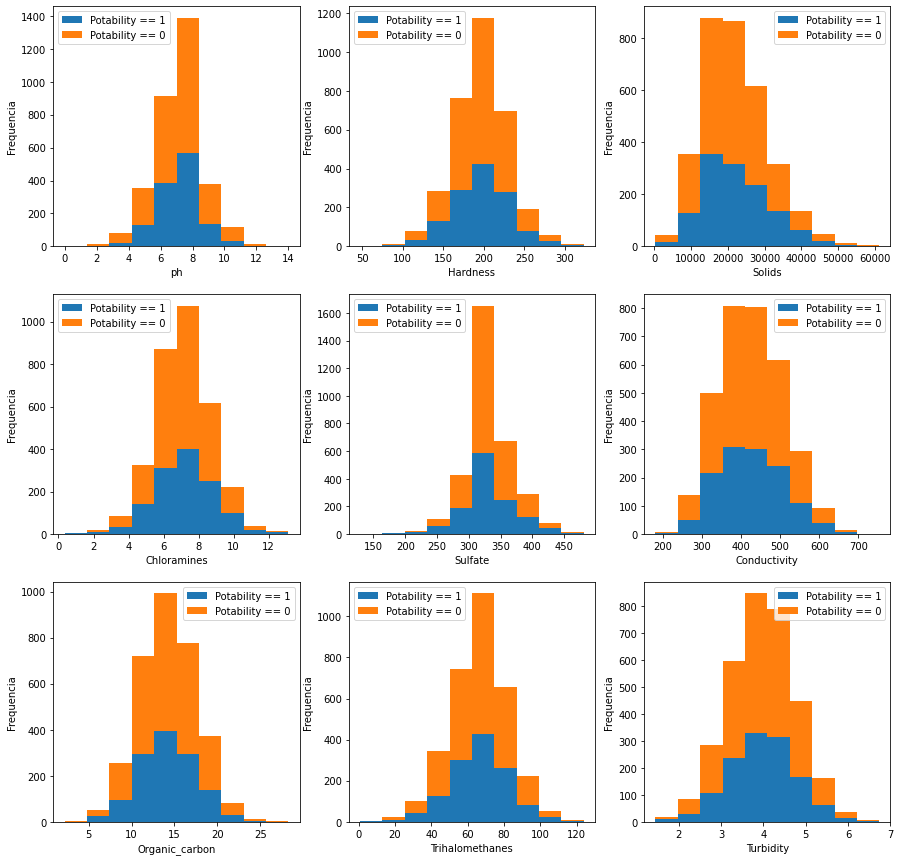

In [ ]:
# Vizualizando ocorrência de potabilidade por faixa de valor de cada propriedade
plt.figure(figsize=(15, 15), num='corr_ajustada sem pot')
n = 1
for i in ['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']:
    plt.subplot(3, 3, n)
    n+=1
    plt.hist([df_agua1.loc[df_agua1['Potability']==1][i], df_agua1.loc[df_agua1['Potability']==0][i]], stacked=True)
    plt.xlabel(i)
    plt.ylabel('Frequencia')
    plt.legend(('Potability == 1', 'Potability == 0'))
plt.show()

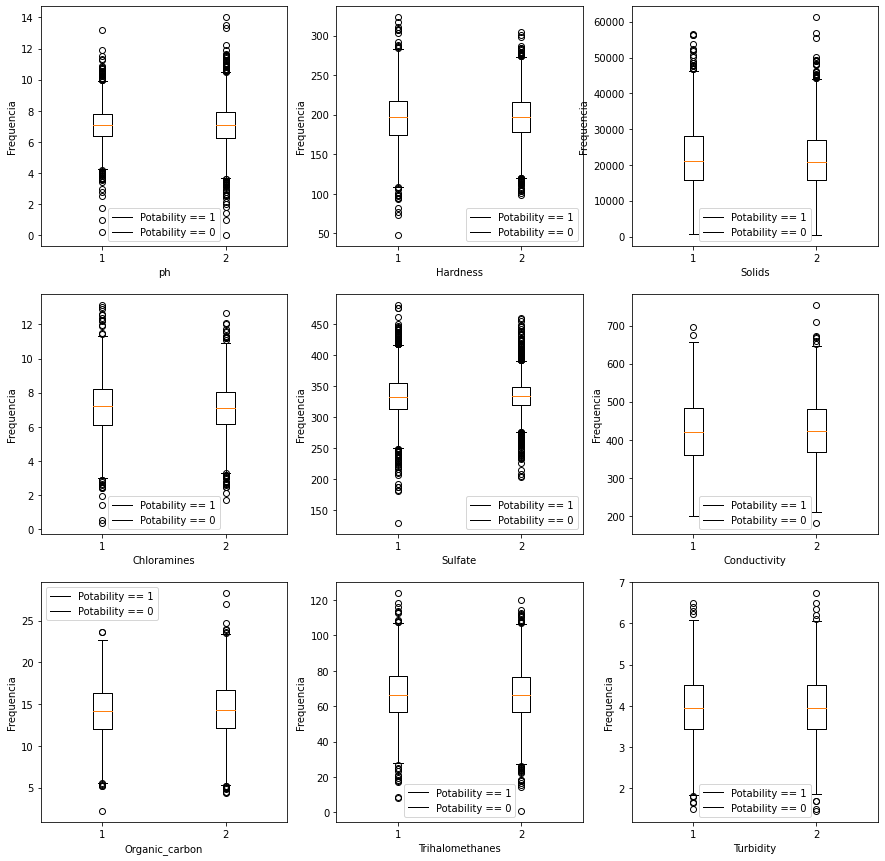

In [ ]:
# Dispersão de valores com base na média
plt.figure(figsize=(15, 15), num='corr_ajustada sem pot')
n = 1
for i in ['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']:
    plt.subplot(3, 3, n)
    n+=1
    plt.boxplot([df_agua1.loc[df_agua1['Potability']==1][i], df_agua1.loc[df_agua1['Potability']==0][i]])
    plt.xlabel(i)
    plt.ylabel('Frequencia')
    plt.legend(('Potability == 1', 'Potability == 0'))
plt.show()

In [ ]:
# Detalhes das medidas de descrição - potável
df_agua1.loc[df_agua1['Potability'] == 1].describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.0
mean,7.073783,195.800744,22383.991018,7.169338,332.566990,425.383800,14.160893,66.539684,3.968328,1.0
std,1.343952,35.547041,9101.010208,1.702988,41.865385,82.048446,3.263907,15.971941,0.780842,0.0
min,0.227499,47.432000,728.750830,0.352000,129.000000,201.619737,2.200000,8.175876,1.492207,1.0
25%,6.351824,174.330531,15668.985035,6.094134,313.052947,360.939023,12.033897,56.911186,3.430909,1.0
50%,7.073783,196.632907,21199.386614,7.215163,332.566990,420.712729,14.162809,66.539684,3.958576,1.0
75%,7.780068,218.003420,27973.236446,8.199261,354.807924,484.155911,16.356245,77.067457,4.509569,1.0
max,13.175402,323.124000,56488.672413,13.127000,481.030642,695.369528,23.604298,124.000000,6.494249,1.0


In [ ]:
# Detalhes das medidas de descrição - não potável
df_agua1.loc[df_agua1['Potability'] == 0].describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.0
mean,7.085378,196.733292,21777.490788,7.092175,334.564290,426.730454,14.364335,66.303555,3.965800,0.0
std,1.545489,31.057540,8543.068788,1.501045,31.941870,80.047317,3.334554,15.642622,0.780282,0.0
min,0.000000,98.452931,320.942611,1.683993,203.444521,181.483754,4.371899,0.738000,1.450000,0.0
25%,6.224046,177.823265,15663.057382,6.155640,319.354715,368.498530,12.101057,56.441831,3.444062,0.0
50%,7.085378,197.123423,20809.618280,7.090334,334.564290,422.229331,14.293508,66.303555,3.948076,0.0
75%,7.940697,216.120687,27006.249009,8.066462,348.316746,480.677198,16.649485,76.518849,4.496106,0.0
max,14.000000,304.235912,61227.196008,12.653362,460.107069,753.342620,28.300000,120.030077,6.739000,0.0


# Considerações finais sobre a análise *como um todo*

Ao final das 3 análises, é possível concluir que XXXXX.

Concluir que, após a identificação da correlação dos dados, verificação e preenchimento de dados ausentes, utilização e comparação de outliers, XXXXX


#  Iniciando modelos de classificação

# O que é um modelo de regressão?
*Expliação de como funciona o modelo de regressão.*

 O método de análise permite estimar o valor de uma determinada variável resposta (variável dependente) como função de outras variáveis preditoras (variáveis independentes).  Nele, a estimação dos mínimos quadrados ordinários – MQO é uma técnica de otimização dos quadrados do erro da regressão. **Esse método de análise é bastante potente**, contudo, 
 
 Apesar de esse método de análise ser muito eficaz, é preciso haver cuidado, visto que os resultados tendem a ser enviesados. Isso acontece porque o método é ancorado em alguns pressupostos que precisam ser respeitados. No caso, os testes são todos baseados no pressuposto da normalidade. Sendo assim, se a análise de  uma variável que não possui distribuição normal **com o método**, os resultados não serão satisfatórios. 

*Também comentar sobre Navy Beils*

Também, é importante comentar sobre o classificador probabilístico “Naive Bayes”, um dos mais utilizados para categorizar textos com base na frequência das palavras usadas. O método pode ser usado quando os atributos que descrevem as instâncias forem condicionalmente independentes, ou seja, quando se trata sobre probabilidade condicional. O classificador se faz excelente na resolução de problemas relacionado a textos, realizando a filtragem. Além disso, o algoritmo é muito robusto nas previsões em tempo real, ainda mais por precisar de poucos dados para a realização. Contudo, caso tenha a necessidade de correlacionar fatores, classificador tende a ter falhas na predição. 

### Exibir Dados

In [ ]:
def metricas(tt_spit, lista_dados):
    arrays = [['Cout','Cout','Cout','Cout','Cout','Cout','Cout','Cout','Sout','Sout','Sout','Sout','Sout','Sout','Sout','Sout'],['Vp','Vn','Fp','Fn','acuracia_treino','acuracia_teste','precision_treino','precision_teste','Vp','Vn','Fp','Fn','acuracia_treino','acuracia_teste','precision_treino','precision_teste']]
    tuples = list(zip(*arrays))
    dic_ite = [[] for i in range(len(tt_spit[0]))]
    index = ['iteracao' + str(i+1) for i in range(len(tt_spit[0]))]
    columns = pd.MultiIndex.from_tuples(tuples)
    for j in range(len(tt_spit)):
        plt.figure(figsize=(20, 20), num=''.join('Cout' if j == 0 else 'Sout'))
        n=1
        acuracia_treino = [i[0][0] for i in lista_dados[j]]
        acuracia_teste = [i[0][1] for i in lista_dados[j]]
        predicao = [i[0][2] for i in lista_dados[j]]
        precision_treino = [i[1][0] for i in lista_dados[j]]
        precision_teste = [i[1][1] for i in lista_dados[j]]
        for i in range(len(tt_spit[j])):
            Train_X = tt_spit[j][i][0]; Test_X = tt_spit[j][i][1]; Train_Y = tt_spit[j][i][2]; Test_Y = tt_spit[j][i][3]
            Vn, Fp, Fn, Vp = cm(Test_Y, predicao[i]).ravel()
            dic_ite[i].append(Vp)
            dic_ite[i].append(Vn)
            dic_ite[i].append(Fp)
            dic_ite[i].append(Fn)
            dic_ite[i].append(acuracia_treino[i])
            dic_ite[i].append(acuracia_teste[i])
            dic_ite[i].append(precision_treino[i])
            dic_ite[i].append(precision_teste[i])
            plt.subplot(3, 4, n)
            mc = cm(Test_Y, predicao[i])
            cmap = sns.diverging_palette(255, 10, as_cmap=True)
            sns.heatmap(mc, cmap=cmap, annot=True, square=True, linewidths=1)
            plt.title(f'iteracao {n}\nacuracia {acuracia_teste[i]}')
            n+=1
        plt.subplot(3, 4, 12)
        plt.hist([round(i) for i in acuracia_teste])
        plt.xlabel('Acuracia')
        plt.ylabel('Frequencia')
        plt.show()
    df = pd.DataFrame(dic_ite, index=index, columns=columns)
    df[('Cout-Sout','acuracia_treino')] = df[('Cout','acuracia_treino')] - df[('Sout','acuracia_treino')]
    df[('Cout-Sout','acuracia_teste')] = df[('Cout','acuracia_teste')] - df[('Sout','acuracia_teste')]
    df[('Cout-Sout','precision_treino')] = df[('Cout','precision_treino')] - df[('Sout','precision_treino')]
    df[('Cout-Sout','precision_teste')] = df[('Cout','precision_teste')] - df[('Sout','precision_teste')]
    return df

## Random Forest Classifier. 
*Explicacao sobre como que o RF funciona*

Começando pelo nome, o classificador Random Forest já contém a palavra "aleatório", que denota o comportamento do algortimo ao selecionar subconjuntos de features e montar árvores de decisão. Já com o segundo nome, Forest, significa floresta, representando a grande quantidade de árvores de decisão geradas. Para funcionar, o algoritmo realiza uma seleção aleatória de algumas fontes, da feature mais adequada para a posição do nó raiz, gera os nós filhos e acaba repetindo esse processo até atingir a quantidade de arvores desejada no projeto. Após a geração do modelo, as previsões são feitas tendo a partir de uma espécie de votação. Cada árvore realiza uma decisão a partir dos dados apresentados. Desse modo, a decisão que possuir mais votos é a resposta do algortimo. O Random Forest é, relativamente, de fácil entendimento de seu funcionamento, bastante útil para resolver problemas de regressão e classificação, apresentando resultados satisfatórios em situações variadas, com um bom desenpenho, e possui implementações em várias bibliotecas de IA disponível atualmente.

Fonte: [medium](https://medium.com/cinthiabpessanha/random-forest-como-funciona-um-dos-algoritmos-mais-populares-de-ml-cc1b8a58b3b4)


In [ ]:
def RF_Clf(Train_X, Test_X, Train_Y, Test_Y):
    RF_clf = RandomForestC()
    RF_clf.fit(Train_X, Train_Y)
    RF_train_score = RF_clf.score(Train_X, Train_Y)*100
    RF_test_score = RF_clf.score(Test_X, Test_Y)*100
    RF_train_pred = RF_clf.predict(Train_X)
    RF_test_pred = RF_clf.predict(Test_X)
    RF_train_Recalscore = precision_score(Train_Y, RF_train_pred)*100
    RF_test_Recalscore = precision_score(Test_Y, RF_test_pred)*100
    return [[RF_train_score, RF_test_score, RF_test_pred], [RF_train_Recalscore, RF_test_Recalscore]]

## XGBoost Classifier. 
*Explicacao sobre como que o XG_BOOST funciona*

O XGBoost é um algoritmo de aprendizado de máquina, tambem baseado em árvores de decisão e que faz uso de uma estrutura de Gradiente boosting. Esse algoritmo é satisfatório pois pode ser usado em uma variedade de situações, , como regressão, classificação, ranqueamento, entre outros, além de ser compatível nos 3 sistemas operacionais mais comuns - Windows, Linux e OS X. Outra vantagem é que ele suporta as prinipais linguagens de programação - no caso desse projeto: Python. Seu algoritmo de gradiente descendente é capaz de minimizar erros, combinando técnicas de otimização de software e hardware para otimizar os recursos computacionais em menos tempo.


In [ ]:
def XGB_Clf(Train_X, Test_X, Train_Y, Test_Y):
    XGB_clf = GradientBoostingC()
    XGB_clf.fit(Train_X, Train_Y)
    XGB_train_score = XGB_clf.score(Train_X, Train_Y)*100
    XGB_test_score = XGB_clf.score(Test_X, Test_Y)*100
    XGB_train_pred = XGB_clf.predict(Train_X)
    XGB_test_pred = XGB_clf.predict(Test_X)
    XGB_train_precision_score = precision_score(Train_Y, XGB_train_pred)*100
    XGB_test_precision_score = precision_score(Test_Y, XGB_test_pred)*100
    return [[XGB_train_score, XGB_test_score, XGB_test_pred], [XGB_train_precision_score, XGB_test_precision_score]]

## Logistic Regression.
*Explicação de como funciona a regressão geral. Depois, sobre a linear em específico*

In [ ]:
def LogReg(Train_X, Test_X, Train_Y, Test_Y):
    Log_reg = Logit(Train_Y, Train_X).fit(disp=0)
    LR_train_pred = Log_reg.predict(Train_X)
    LR_test_pred = Log_reg.predict(Test_X)
    LR_train_precisionscore = precision_score(Train_Y, round(LR_train_pred))*100
    LR_test_precisionscore = precision_score(Test_Y, round(LR_test_pred))*100
    return [[accuracy_score(Train_Y, round(LR_train_pred))*100, accuracy_score(Test_Y, round(LR_test_pred))*100, round(LR_test_pred)], [LR_train_precisionscore, LR_test_precisionscore]]

## Neural Network. 
*Explicação de como a Neural Network funciona. Texto longo*

In [ ]:
def my_neural_network(Train_X, Test_X, Train_Y, Test_Y, optimizer='rmsprop', loss=None, metrics=None, loss_weights=None, weighted_metrics=None, run_eagerly=None, steps_per_execution=None, epochs=50, batch_size=1, verbose=1):

    normalizer = StandardScaler().fit(Train_X)

    Train_X = normalizer.transform(Train_X)

    Test_X = normalizer.transform(Test_X)

    model = Sequential()

    model.add(Dense(units=16, activation='relu', input_shape=(9,)))

    model.add(Dense(units=16, activation='relu'))

    model.add(Dense(units=16, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights, weighted_metrics=weighted_metrics, run_eagerly=run_eagerly, steps_per_execution=steps_per_execution)

    model.fit(Train_X, Train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose)

    Predict_Y = model.predict(Test_X)
    score = model.evaluate(Test_X, Test_Y,verbose=1, return_dict=True)
    return score

# Rodando os classificadores

In [ ]:
listaCout_tts = []; listaSout_tts = []; lista_tts = [[], []]; lista_RF = [[], []]; lista_XGB = [[], []]; lista_LR = [[], []]
for i in range(11):
    ttCout_split = tts(df_agua1.drop(['Potability'], axis=1), df_agua1.Potability, test_size=0.25)
    ttSout_split = tts(df_agua1_Sout.drop(['Potability'], axis=1), df_agua1_Sout.Potability, test_size=0.25)
    lista_tts[0].append(ttCout_split)
    lista_tts[1].append(ttSout_split)
    lista_RF[0].append(RF_Clf(ttCout_split[0], ttCout_split[1], ttCout_split[2], ttCout_split[3]))
    lista_RF[1].append(RF_Clf(ttSout_split[0], ttSout_split[1], ttSout_split[2], ttSout_split[3]))
    lista_XGB[0].append(XGB_Clf(ttCout_split[0], ttCout_split[1], ttCout_split[2], ttCout_split[3]))
    lista_XGB[1].append(XGB_Clf(ttSout_split[0], ttSout_split[1], ttSout_split[2], ttSout_split[3]))
    lista_LR[0].append(LogReg(ttCout_split[0], ttCout_split[1], ttCout_split[2], ttCout_split[3]))
    lista_LR[1].append(LogReg(ttSout_split[0], ttSout_split[1], ttSout_split[2], ttSout_split[3]))

e:\projetos\py-charm\cdados\projetos\p2-cdados-2021-2\venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\projetos\py-charm\cdados\projetos\p2-cdados-2021-2\venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\projetos\py-charm\cdados\projetos\p2-cdados-2021-2\venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\projetos\py-c

## Random Forest
*Descrever as expectativas para os resultados gerados. Lembrando que os primeiros gráficos são com outliers, e os segundo sem. O que nós achamos sobre os resultados gerados?*

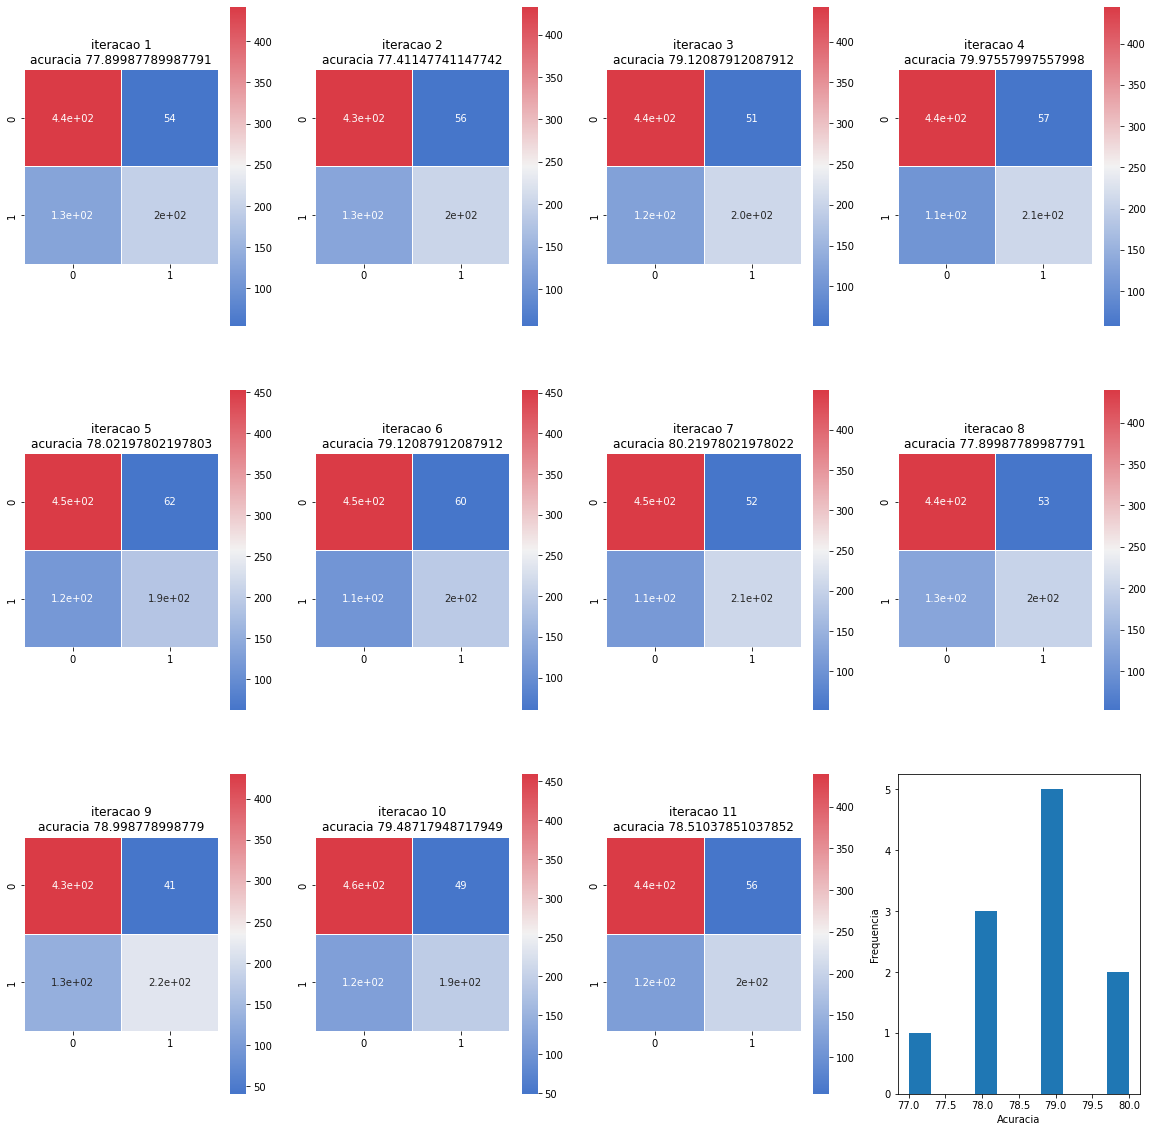

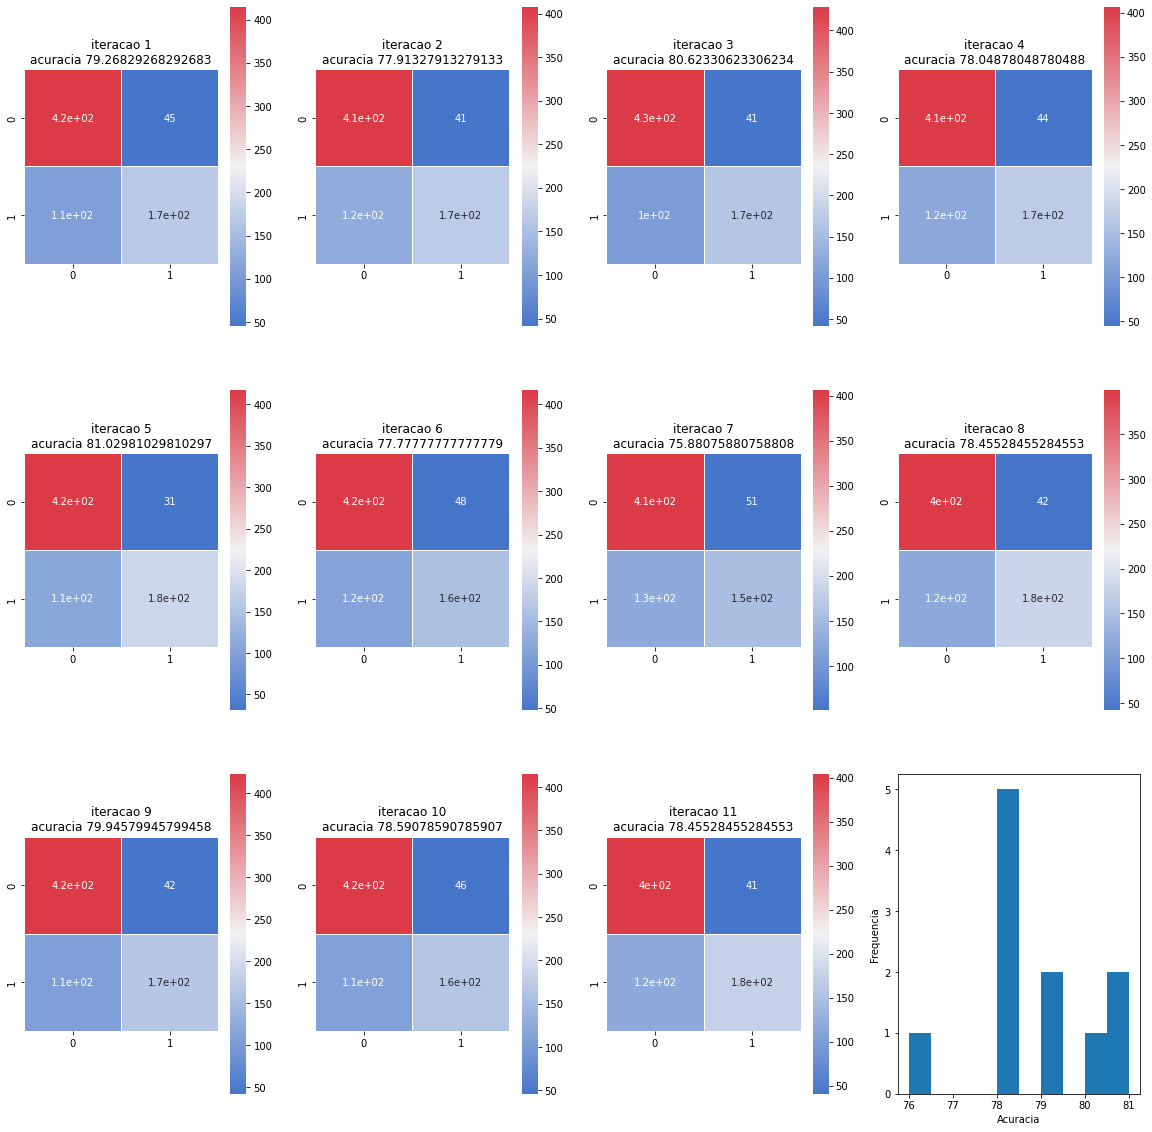

Cout                                                                \
             Vp   Vn  Fp   Fn acuracia_treino acuracia_teste precision_treino   
iteracao1   196  442  54  127           100.0      77.899878            100.0   
iteracao2   201  433  56  129           100.0      77.411477            100.0   
iteracao3   205  443  51  120           100.0      79.120879            100.0   
iteracao4   210  445  57  107           100.0      79.975580            100.0   
iteracao5   187  452  62  118           100.0      78.021978            100.0   
iteracao6   195  453  60  111           100.0      79.120879            100.0   
iteracao7   208  449  52  110           100.0      80.219780            100.0   
iteracao8   199  439  53  128           100.0      77.899878            100.0   
iteracao9   217  430  41  131           100.0      78.998779            100.0   
iteracao10  192  459  49  119           100.0      79.487179            100.0   
iteracao11  204  439  56  120           100.0      78.510379            100.0   

                           Sout                                               \
           precision_teste   Vp   Vn  Fp   Fn acuracia_treino acuracia_teste   
iteracao1        78.400000  170  415  45  108           100.0      79.268293   
iteracao2        78.210117  167  408  41  122           100.0      77.913279   
iteracao3        80.078125  166  429  41  102           100.0      80.623306   
iteracao4        78.651685  169  407  44  118           100.0      78.048780   
iteracao5        75.100402  181  417  31  109           100.0      81.029810   
iteracao6        76.470588  158  416  48  116           100.0      77.777778   
iteracao7        80.000000  154  406  51  127           100.0      75.880759   
iteracao8        78.968254  180  399  42  117           100.0      78.455285   
iteracao9        84.108527  167  423  42  106           100.0      79.945799   
iteracao10       79.668050  165  415  46  112           100.0      78.590786   
iteracao11       78.461538  175  404  41  118           100.0      78.455285   

                                                  Cout-Sout                 \
           precision_treino precision_teste acuracia_treino acuracia_teste   
iteracao1             100.0       79.069767             0.0      -1.368415   
iteracao2             100.0       80.288462             0.0      -0.501802   
iteracao3             100.0       80.193237             0.0      -1.502427   
iteracao4             100.0       79.342723             0.0       1.926799   
iteracao5             100.0       85.377358             0.0      -3.007832   
iteracao6             100.0       76.699029             0.0       1.343101   
iteracao7             100.0       75.121951             0.0       4.339021   
iteracao8             100.0       81.081081             0.0      -0.555407   
iteracao9             100.0       79.904306             0.0      -0.947020   
iteracao10            100.0       78.199052             0.0       0.896394   
iteracao11            100.0       81.018519             0.0       0.055094   

                                             
           precision_treino precision_teste  
iteracao1               0.0       -0.669767  
iteracao2               0.0       -2.078345  
iteracao3               0.0       -0.115112  
iteracao4               0.0       -0.691038  
iteracao5               0.0      -10.276957  
iteracao6               0.0       -0.228441  
iteracao7               0.0        4.878049  
iteracao8               0.0       -2.112827  
iteracao9               0.0        4.204221  
iteracao10              0.0        1.468998  
iteracao11              0.0       -2.556980

In [ ]:
metricas(lista_tts, lista_RF)

## XG_BOOST. Expectativas para os resultados gerados
*Explicação leve do XG, lembrando que os primeiros grpaficos são com outliers e os segundos sem.*

In [ ]:
metricas(lista_tts, lista_XGB)

NameError: name 'metricas' is not defined

## Logistic Regression: Expectativas para os resultados gerados
*Explicação leve do XG, lembrando que os primeiros grpaficos são com outliers e os segundos sem.*

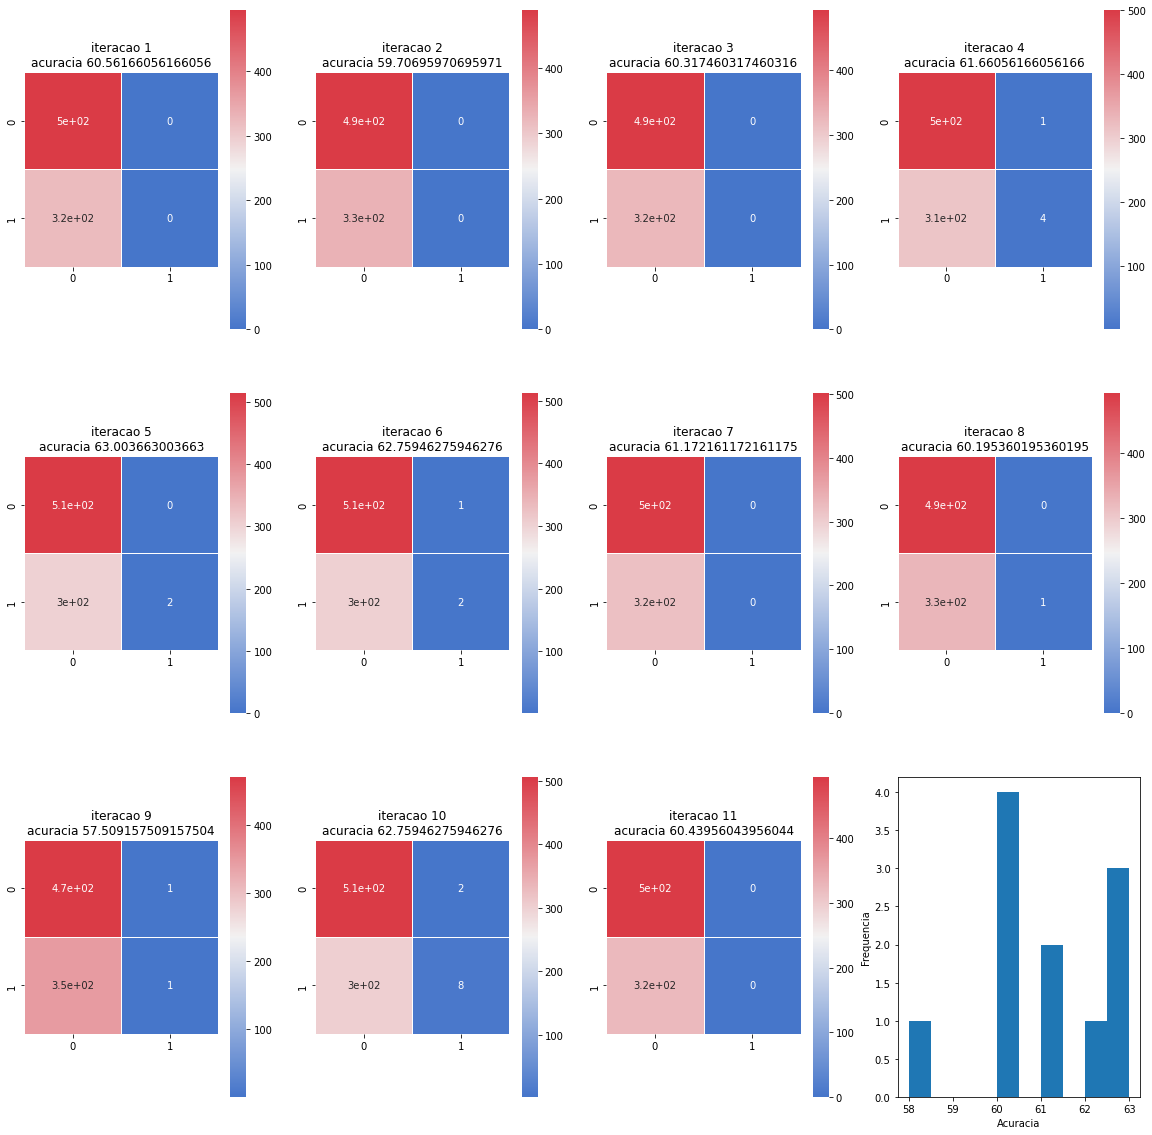

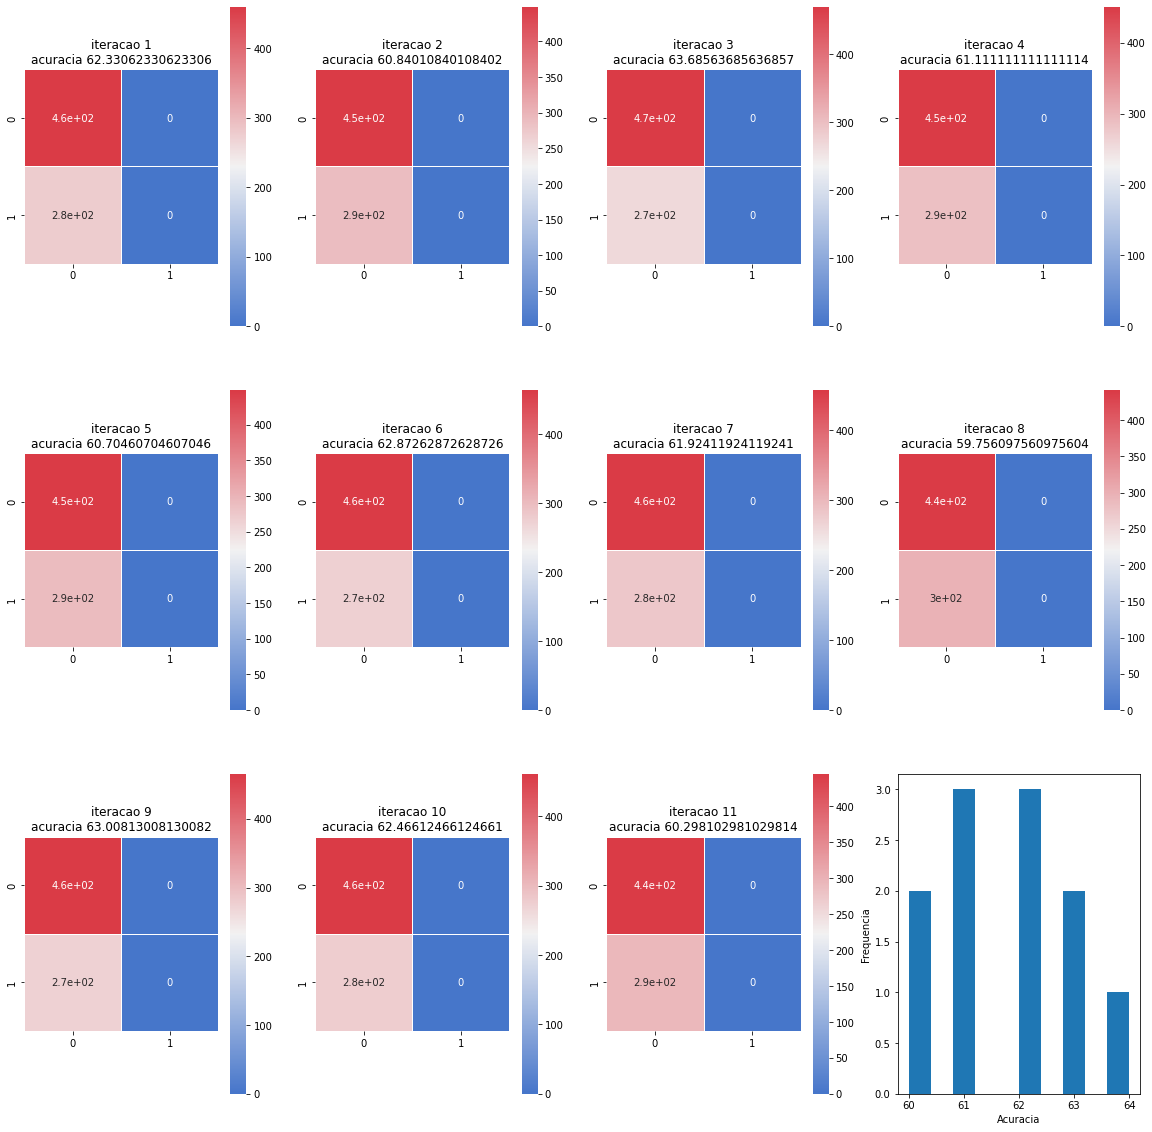

Cout                                                               \
             Vp   Vn Fp   Fn acuracia_treino acuracia_teste precision_treino   
iteracao1     0  496  0  323       61.131461      60.561661        50.000000   
iteracao2     0  489  0  330       61.416361      59.706960         0.000000   
iteracao3     0  494  0  325       61.253561      60.317460       100.000000   
iteracao4     4  501  1  313       61.172161      61.660562        81.818182   
iteracao5     2  514  0  303       60.561661      63.003663       100.000000   
iteracao6     2  512  1  304       60.724461      62.759463        81.818182   
iteracao7     0  501  0  318       61.009361      61.172161       100.000000   
iteracao8     1  492  0  326       61.538462      60.195360       100.000000   
iteracao9     1  470  1  347       62.596663      57.509158       100.000000   
iteracao10    8  506  2  303       61.212861      62.759463        71.875000   
iteracao11    0  495  0  324       61.131461      60.439560         0.000000   

                           Sout                                              \
           precision_teste   Vp   Vn Fp   Fn acuracia_treino acuracia_teste   
iteracao1         0.000000    0  460  0  278       61.635789      62.330623   
iteracao2         0.000000    0  449  0  289       62.132851      60.840108   
iteracao3         0.000000    0  470  0  268       61.183913      63.685637   
iteracao4        80.000000    0  451  0  287       62.042476      61.111111   
iteracao5       100.000000    0  448  0  290       62.178039      60.704607   
iteracao6        66.666667    0  464  0  274       61.455038      62.872629   
iteracao7         0.000000    0  457  0  281       61.997289      61.924119   
iteracao8       100.000000    0  441  0  297       62.494352      59.756098   
iteracao9        50.000000    0  465  0  273       61.409851      63.008130   
iteracao10       80.000000    0  461  0  277       61.590601      62.466125   
iteracao11        0.000000    0  445  0  293       62.313601      60.298103   

                                                  Cout-Sout                 \
           precision_treino precision_teste acuracia_treino acuracia_teste   
iteracao1               0.0             0.0       -0.504327      -1.768963   
iteracao2               0.0             0.0       -0.716490      -1.133149   
iteracao3               0.0             0.0        0.069648      -3.368177   
iteracao4               0.0             0.0       -0.870315       0.549451   
iteracao5               0.0             0.0       -1.616378       2.299056   
iteracao6               0.0             0.0       -0.730578      -0.113166   
iteracao7             100.0             0.0       -0.987928      -0.751958   
iteracao8               0.0             0.0       -0.955890       0.439263   
iteracao9               0.0             0.0        1.186812      -5.498973   
iteracao10              0.0             0.0       -0.377740       0.293338   
iteracao11              0.0             0.0       -1.182140       0.141457   

                                             
           precision_treino precision_teste  
iteracao1         50.000000        0.000000  
iteracao2          0.000000        0.000000  
iteracao3        100.000000        0.000000  
iteracao4         81.818182       80.000000  
iteracao5        100.000000      100.000000  
iteracao6         81.818182       66.666667  
iteracao7          0.000000        0.000000  
iteracao8        100.000000      100.000000  
iteracao9        100.000000       50.000000  
iteracao10        71.875000       80.000000  
iteracao11         0.000000        0.000000

In [ ]:
metricas(lista_tts, lista_LR)

## Neural Network (Simulated only once).
*Explicar porque já era esperado que o desempenho da Neural Network não iria ser plausível para o projeto*

### Com Outliers

In [ ]:
my_neural_network(ttSout_split[0], ttSout_split[1], ttSout_split[2], ttSout_split[3], loss='binary_crossentropy', metrics=['accuracy'], epochs=50)

Epoch 1/50
2213/2213 [==============================] - 1s 520us/step - loss: 0.6775 - accuracy: 0.6087
Epoch 2/50
2213/2213 [==============================] - 1s 521us/step - loss: 0.6578 - accuracy: 0.6227
Epoch 3/50
2213/2213 [==============================] - 1s 530us/step - loss: 0.6404 - accuracy: 0.6417
Epoch 4/50
2213/2213 [==============================] - 1s 528us/step - loss: 0.6330 - accuracy: 0.6566
Epoch 5/50
2213/2213 [==============================] - 1s 511us/step - loss: 0.6276 - accuracy: 0.6692
Epoch 6/50
2213/2213 [==============================] - 1s 532us/step - loss: 0.6251 - accuracy: 0.6706
Epoch 7/50
2213/2213 [==============================] - 1s 522us/step - loss: 0.6269 - accuracy: 0.6805
Epoch 8/50
2213/2213 [==============================] - 1s 531us/step - loss: 0.6272 - accuracy: 0.6846
Epoch 9/50
2213/2213 [==============================] - 1s 522us/step - loss: 0.6278 - accuracy: 0.6864
Epoch 10/50
2213/2213 [==============================] - 1s 505u

{'loss': 0.8547335863113403, 'accuracy': 0.6869918704032898}

### Sem Outliers

In [ ]:
my_neural_network(ttSout_split[0], ttSout_split[1], ttSout_split[2], ttSout_split[3], loss='binary_crossentropy', metrics=['accuracy'], epochs=50)

Epoch 1/50
2213/2213 [==============================] - 2s 540us/step - loss: 0.6782 - accuracy: 0.6001
Epoch 2/50
2213/2213 [==============================] - 1s 527us/step - loss: 0.6636 - accuracy: 0.6105
Epoch 3/50
2213/2213 [==============================] - 1s 549us/step - loss: 0.6563 - accuracy: 0.6146
Epoch 4/50
2213/2213 [==============================] - 1s 523us/step - loss: 0.6580 - accuracy: 0.6272
Epoch 5/50
2213/2213 [==============================] - 1s 521us/step - loss: 0.6563 - accuracy: 0.6281
Epoch 6/50
2213/2213 [==============================] - 1s 526us/step - loss: 0.6516 - accuracy: 0.6344
Epoch 7/50
2213/2213 [==============================] - 1s 533us/step - loss: 0.6410 - accuracy: 0.6606
Epoch 8/50
2213/2213 [==============================] - 1s 537us/step - loss: 0.6422 - accuracy: 0.6579
Epoch 9/50
2213/2213 [==============================] - 1s 551us/step - loss: 0.6351 - accuracy: 0.6733
Epoch 10/50
2213/2213 [==============================] - 1s 530u

{'loss': 0.8455836772918701, 'accuracy': 0.6056910753250122}

# Considerações finais sobre os modelos e os dados gerados por eles.
*Explicação muito leve sobre NN. Explicar consideração de todos os modelos. Comentar que o NN é muito bom, pra não serve pra nossa base de dados porque é muito pequena, os dados acabariam antes do modelo chegar a uma conclusão confiável, visto que ele funciona muito melhor com grandes base de dados.*

# Evitando falsos positivos: a importância da definição correta
Nesse projeto, é necessário evitar falsos positivos, visto que, ao considerar uma água potável e segura para consumo quando isso não é verdade, ou seja, quando acontece um falso positivo, torna-se perigoso para a pessoa que for ingerir esta água. Assim, a chance de uma pessoa ingerir uma água teoricamente segura, quando perigosa, diminui. Como consequência, mais águas seguras serão descartadas, em virtude da segurança das pessoas que irão consumir a água.

# Random Forest

In [ ]:
def RF_Clf_Fn(Train_X, Test_X, Train_Y, Test_Y):
    RF_clf = RandomForestC()
    RF_clf.fit(Train_X, Train_Y)
    RF_train_predicted_proba = RF_clf.predict_proba(Train_X)
    RF_train_pred = (RF_train_predicted_proba [:,1] >= 0.8).astype('int')
    RF_test_predicted_proba = RF_clf.predict_proba(Test_X)
    RF_test_pred = (RF_test_predicted_proba [:,1] >= 0.8).astype('int')
    RF_train_score = accuracy_score(Train_Y, RF_train_pred)*100
    RF_train_Precisionscore = precision_score(Train_Y, RF_train_pred)*100
    RF_test_score = accuracy_score(Test_Y, RF_test_pred)*100
    RF_test_Precisionscore = precision_score(Test_Y, RF_test_pred)*100
    return [[RF_train_score, RF_test_score, RF_test_pred], [RF_train_Precisionscore, RF_test_Precisionscore]]

# XG_BOOST

In [ ]:
def XGB_Clf_Fn(Train_X, Test_X, Train_Y, Test_Y):
    XGB_clf = RandomForestC()
    XGB_clf.fit(Train_X, Train_Y)
    XGB_train_predicted_proba = XGB_clf.predict_proba(Train_X)
    XGB_train_pred = (XGB_train_predicted_proba [:,1] >= 0.8).astype('int')
    XGB_test_predicted_proba = XGB_clf.predict_proba(Test_X)
    XGB_test_pred = (XGB_test_predicted_proba [:,1] >= 0.8).astype('int')
    XGB_train_score = accuracy_score(Train_Y, XGB_train_pred)*100
    XGB_train_Precisionscore = precision_score(Train_Y, XGB_train_pred)*100
    XGB_test_score = accuracy_score(Test_Y, XGB_test_pred)*100
    XGB_test_Precisionscore = precision_score(Test_Y, XGB_test_pred)*100
    return [[XGB_train_score, XGB_test_score, XGB_test_pred], [XGB_train_Precisionscore, XGB_test_Precisionscore]]

# Rodando os classificadores

In [ ]:
listaCout_tts_Fn = []; listaSout_tts_Fn = []; lista_tts_Fn = [[], []]; lista_RF_Fn = [[], []]; lista_XGB_Fn = [[], []]
for i in range(11):
    ttCout_split = tts(df_agua1.drop(['Potability'], axis=1), df_agua1.Potability, test_size=0.25)
    ttSout_split = tts(df_agua1_Sout.drop(['Potability'], axis=1), df_agua1_Sout.Potability, test_size=0.25)
    lista_tts_Fn[0].append(ttCout_split)
    lista_tts_Fn[1].append(ttSout_split)
    lista_RF[0].append(RF_Clf_Fn(ttCout_split[0], ttCout_split[1], ttCout_split[2], ttCout_split[3]))
    lista_RF[1].append(RF_Clf_Fn(ttSout_split[0], ttSout_split[1], ttSout_split[2], ttSout_split[3]))
    lista_XGB[0].append(XGB_Clf_Fn(ttCout_split[0], ttCout_split[1], ttCout_split[2], ttCout_split[3]))
    lista_XGB[1].append(XGB_Clf_Fn(ttSout_split[0], ttSout_split[1], ttSout_split[2], ttSout_split[3]))

NameError: name 'lista_RF' is not defined

# Random Forets
*Explicação de porque é melhot haver acurácia mais baixa com precisão (% verdadeiros) maior*

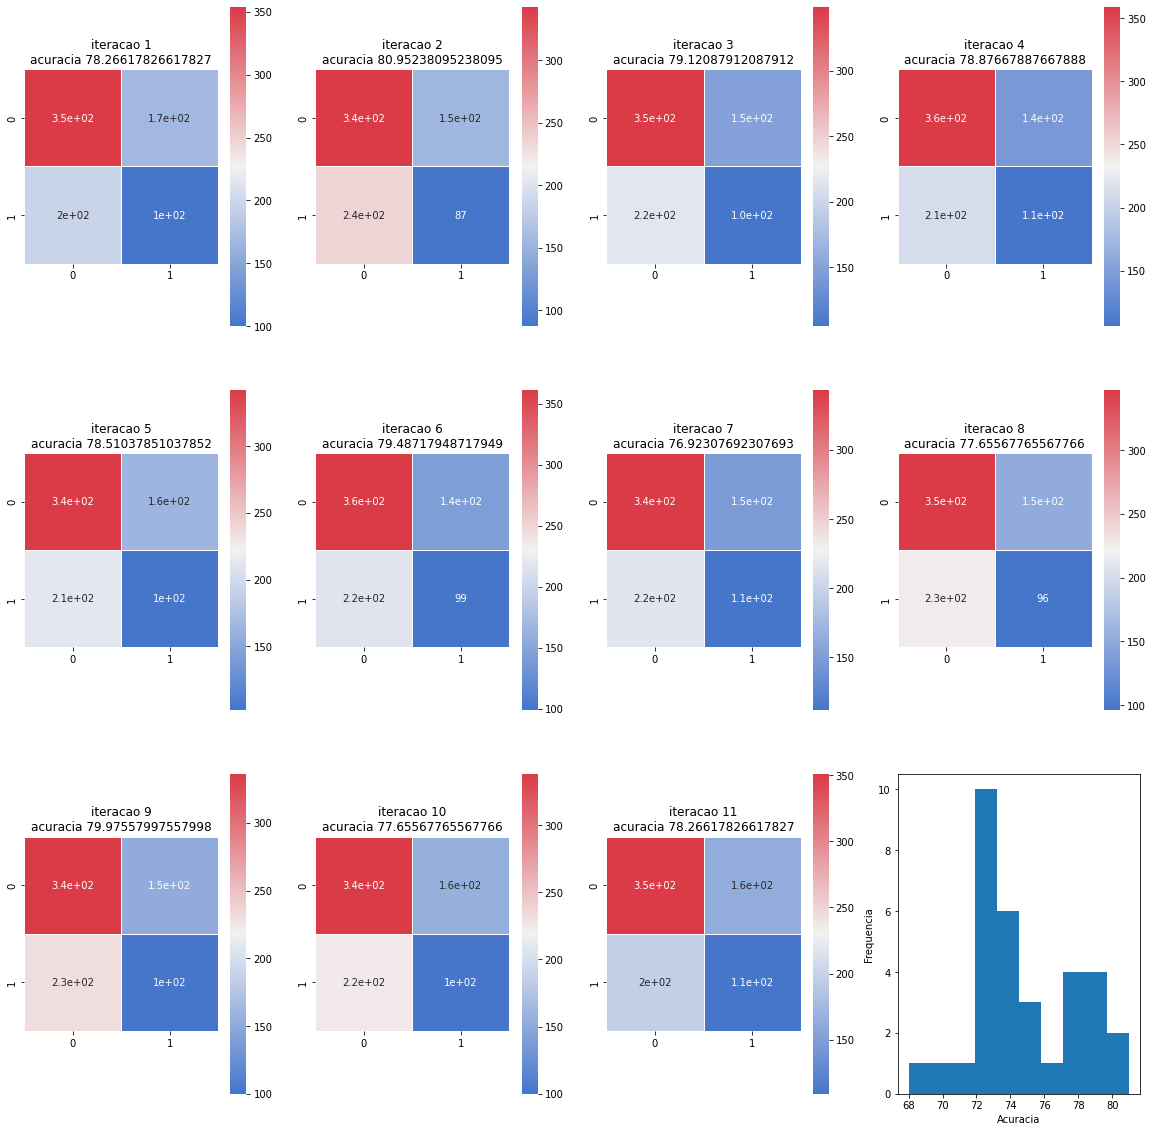

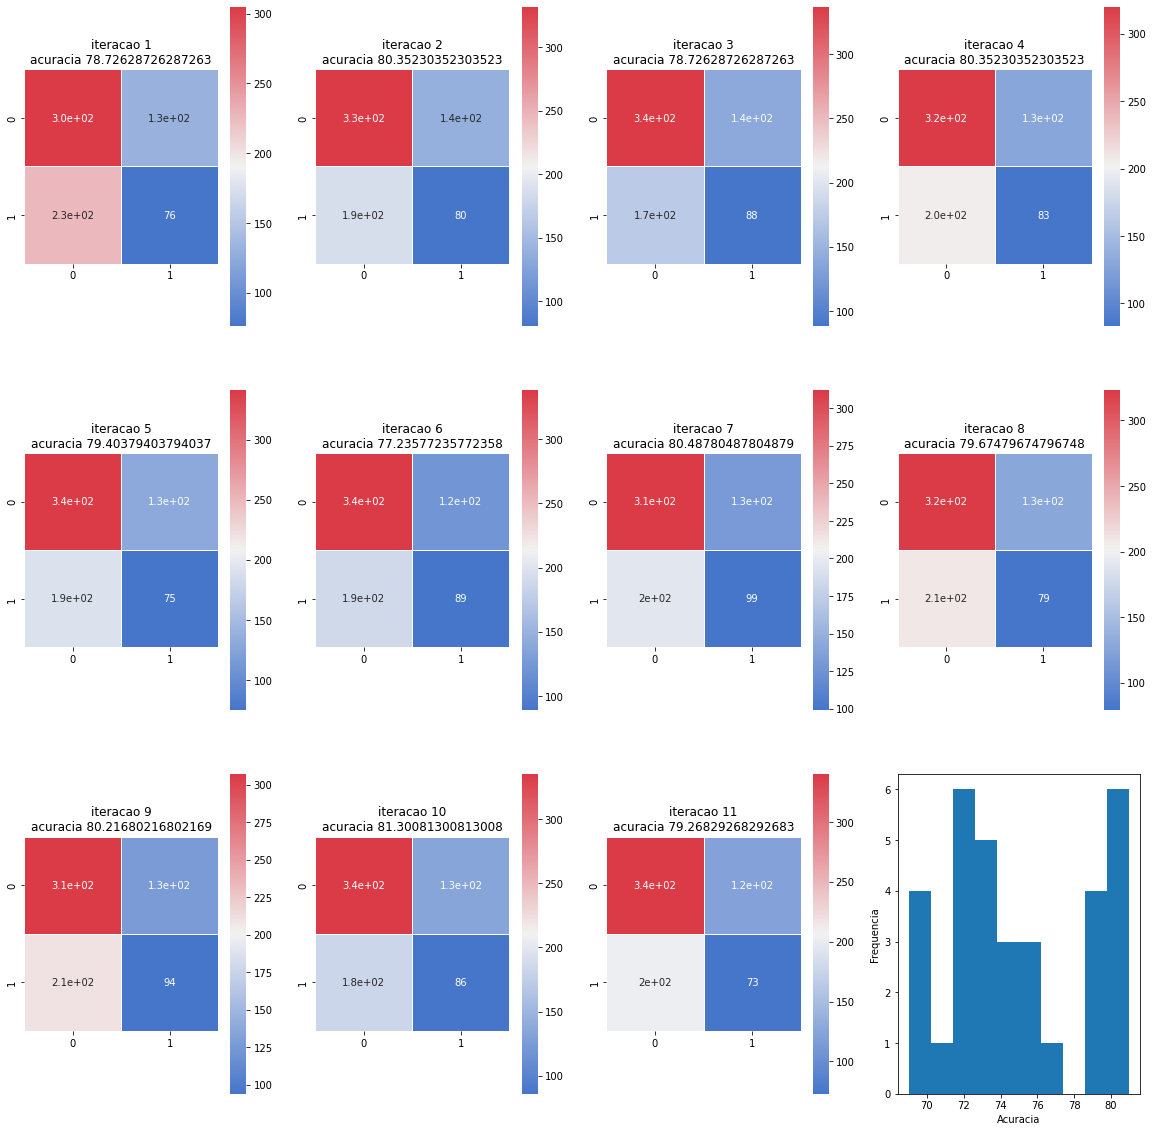

Cout                                                \
             Vp   Vn   Fp   Fn acuracia_treino acuracia_teste   
iteracao1   100  354  168  197           100.0      78.266178   
iteracao2    87  343  154  235           100.0      80.952381   
iteracao3   105  349  149  216           100.0      79.120879   
iteracao4   106  359  143  211           100.0      78.876679   
iteracao5   102  342  163  212           100.0      78.510379   
iteracao6    99  361  143  216           100.0      79.487179   
iteracao7   112  343  148  216           100.0      76.923077   
iteracao8    96  347  150  226           100.0      77.655678   
iteracao9   100  336  152  231           100.0      79.975580   
iteracao10  100  338  156  225           100.0      77.655678   
iteracao11  109  351  163  196           100.0      78.266178   

                                            Sout                 \
           precision_treino precision_teste   Vp   Vn   Fp   Fn   
iteracao1             100.0       77.238806   76  305  131  226   
iteracao2             100.0       80.912863   80  332  140  186   
iteracao3             100.0       80.708661   88  337  140  173   
iteracao4             100.0       78.714859   83  320  130  205   
iteracao5             100.0       80.377358   75  341  131  191   
iteracao6             100.0       78.099174   89  338  122  189   
iteracao7             100.0       78.076923   99  312  131  196   
iteracao8             100.0       77.642276   79  323  128  208   
iteracao9             100.0       82.142857   94  307  127  210   
iteracao10            100.0       79.687500   86  335  134  183   
iteracao11            100.0       77.573529   73  340  122  203   

                                                                            \
           acuracia_treino acuracia_teste precision_treino precision_teste   
iteracao1            100.0      78.726287            100.0       80.193237   
iteracao2            100.0      80.352304            100.0       78.181818   
iteracao3            100.0      78.726287            100.0       76.754386   
iteracao4            100.0      80.352304            100.0       78.403756   
iteracao5            100.0      79.403794            100.0       81.553398   
iteracao6            100.0      77.235772            100.0       77.251185   
iteracao7            100.0      80.487805            100.0       80.869565   
iteracao8            100.0      79.674797            100.0       83.574879   
iteracao9            100.0      80.216802            100.0       81.447964   
iteracao10           100.0      81.300813            100.0       77.272727   
iteracao11           100.0      79.268293            100.0       77.948718   

                 Cout-Sout                                                  
           acuracia_treino acuracia_teste precision_treino precision_teste  
iteracao1              0.0      -0.460109              0.0       -2.954431  
iteracao2              0.0       0.600077              0.0        2.731045  
iteracao3              0.0       0.394592              0.0        3.954275  
iteracao4              0.0      -1.475625              0.0        0.311104  
iteracao5              0.0      -0.893416              0.0       -1.176040  
iteracao6              0.0       2.251407              0.0        0.847989  
iteracao7              0.0      -3.564728              0.0       -2.792642  
iteracao8              0.0      -2.019119              0.0       -5.932603  
iteracao9              0.0      -0.241222              0.0        0.694893  
iteracao10             0.0      -3.645135              0.0        2.414773  
iteracao11             0.0      -1.002114              0.0       -0.375189

In [ ]:
metricas(lista_tts_Fn, lista_RF)

# XG_BOOST
*Mesma explicação que acima*

In [ ]:
metricas(lista_tts_Fn, lista_XGB)

NameError: name 'metricas' is not defined

# Considerações finais do projeto. 
*Os resultados obtidos são satisfatórios? Qual o melhor modelo? E por que? Também, comentar um pouco sobre cada modelo e porque foi usado o Random Forest/ GX Boost, com/sem outliers (lembrando que precisão > acurácia). Falar que apenas esse modelos foram modelados de forma tendenciosa, porque não havia razão para usar esse recurso nas outras opções.*